In [1]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

2023-08-26 10:51:49.935654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 10:51:49.964680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 10:51:49.965678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 10:51:50.574942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


In [2]:
size = 3
sq_size = np.square(size)
sudoku_input_shape = (sq_size, sq_size)

In [3]:
# Create Discrete models

# Implementation Detail 2: Orthogonal Initialization of hidden weights and constant initialization of biases and output weights
# Biases seem to be 0 by default in Keras
hidden_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=np.sqrt(2))
pol_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=0.01)
val_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=1)

def create_policy_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    #x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(9*9*9, activation="linear", kernel_initializer=pol_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pi")
    return model

def create_value_function_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    #x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", kernel_initializer=val_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="V")
    return model


In [4]:
# create sudoku action mask
def action_mask(observation, logits):
    for y, x in np.ndindex(observation.shape):
        if observation[y,x] != 0:
            act_space_ind = y*(sq_size**2)+x*(sq_size)
            #converting from sudoku-board index to action-space index, see env.py
            logits[act_space_ind:act_space_ind+sq_size] = -1e8
    return logits

In [5]:
envs = PPO_Discrete_Environment_Wrapper('Sudoku-x0', 5, action_mask = action_mask, size=size)

In [6]:
pi, V = PPO(envs, create_policy_model(), create_value_function_model(), multi_discrete=False, STEPS_PER_TRAJECTORY=50, TRAIN_EPOCHS = 1000, LEARNING_RATE_START=0.001)

epoch:  0  ; KL:  0  ; LR:  0.001  ; MR:  0
Collection
Tapework
epoch:  1  ; KL:  48.252323  ; LR:  0.000999  ; MR:  -0.908
Collection
Tapework
epoch:  2  ; KL:  34.383205  ; LR:  0.000998  ; MR:  -0.868
Collection
Tapework
epoch:  3  ; KL:  36.983833  ; LR:  0.000997  ; MR:  -0.864
Collection
Tapework
epoch:  4  ; KL:  39.870846  ; LR:  0.000996  ; MR:  -0.888
Collection
Tapework
epoch:  5  ; KL:  32.631752  ; LR:  0.000995  ; MR:  -0.868
Collection
Tapework
epoch:  6  ; KL:  26.89393  ; LR:  0.000994  ; MR:  -0.844
Collection
Tapework
epoch:  7  ; KL:  33.73186  ; LR:  0.000993  ; MR:  -0.88
Collection
Tapework
epoch:  8  ; KL:  24.282925  ; LR:  0.000992  ; MR:  -0.924
Collection
Tapework
epoch:  9  ; KL:  23.440887  ; LR:  0.000991  ; MR:  -0.904
Collection
Tapework
epoch:  10  ; KL:  21.40032  ; LR:  0.00099  ; MR:  -0.876
Collection
Tapework
epoch:  11  ; KL:  18.686823  ; LR:  0.000989  ; MR:  -0.856
Collection
Tapework
epoch:  12  ; KL:  17.39645  ; LR:  0.000988  ; MR:  -0.904

env solved
env solved
env solvedenv solved

env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved
env solved


KeyboardInterrupt: 

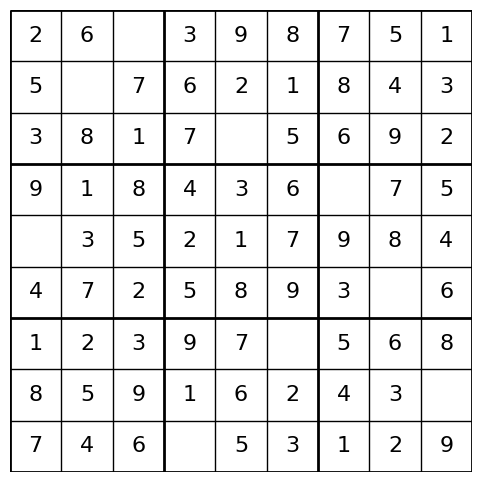

In [7]:

test_env = gym.make('Sudoku-x0', render_mode='human', size=size)
#test_env = gym.make('CartPole-v1', render_mode='human')
obs, inf = test_env.reset()
test_env.render()

667 False -1


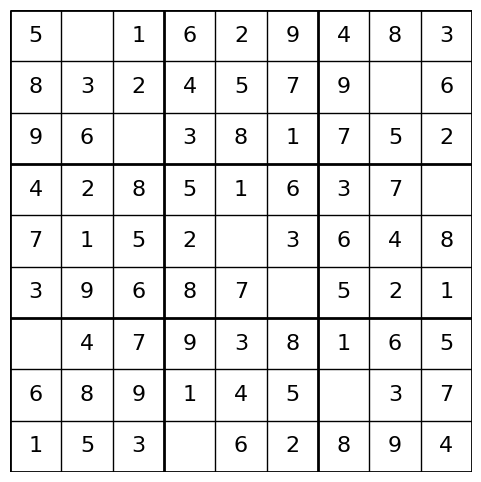

In [15]:
obs, inf = test_env.reset()
qs = pi(tf.expand_dims(obs, 0))
act = np.argmax(qs)
obs, reward, terminated, _, _ = test_env.step(act)
print(act, terminated, reward)
test_env.render()